Last Edited: 2024-01-25

Changes:
* (01-25) Added code to remove 7 datapoints that cause log(0) to the `fashion_mnist()` function
* (01-25) Fixed some typos



------

- **Deadline**: Feb 5, at 23:59PM.
- **Submission**: You need to submit your solutions through Crowdmark, including all your derivations, plots, and your code. You can produce the files however you like (e.g. LATEX, Microsoft Word, etc), as long as it is readable. Points will be deducted if we have a hard time reading your solutions or understanding the structure of your code.
- **Collaboration policy**: After attempting the problems on an individual basis, you may discuss and work together on the assignment with up to two classmates. However, **you must write your own code and write up your own solutions individually and explicitly name any collaborators** at the top of the homework.

# Q1 - Decision Theory

One successful use of probabilistic models is for building spam filters, which take in an email and take different actions depending on the likelihood that it’s spam.

Imagine you are running an email service. You have a well-calibrated spam classifier that tells you the probability that a particular email is spam: $p(spam|email)$. You have four options for what to do with each email: You can list it as important email, show it to the user, put it in the spam folder, or delete it entirely.

Depending on whether or not the email really is spam, the user will suffer a different amount  of wasted time for the different actions we can take, $L$(action, spam):

Action   | Spam        | Not spam
-------- | ----------- | -----------
Important| 15         | 0
Show     | 5          | 1
Folder   | 1           | 40
Delete   | 0           | 150

## Q1.1
[3pts] Plot the expected wasted user time for each of the three possible actions, as a function of the probability of spam: $p(spam|email)$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

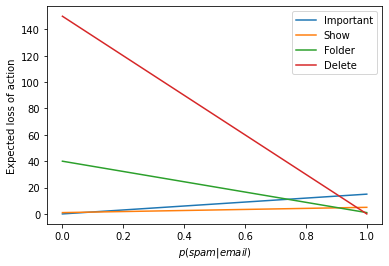

In [ ]:
losses = [[15, 0],[5, 1], [1, 40],[0, 150]]
actions_names = ['Important','Show', 'Folder', 'Delete']
num_actions = len(losses)
def expected_loss_of_action(prob_spam, action):
    #TODO: Return expected loss over a Bernoulli random variable
    # with mean prob_spam.
    # Losses are given by the table above.

    return prob_spam * losses[action][0] + (1 - prob_spam) * losses[action][1]

prob_range = np.linspace(0., 1., num=600)

# Make plot
for action in range(num_actions):
    plt.plot(prob_range, expected_loss_of_action(prob_range, action), label=actions_names[action])

plt.xlabel('$p(spam|email)$')
plt.ylabel('Expected loss of action')
plt.legend()


## Q1.2
[2pts] Write a function that computes the optimal action given the probability of spam.

In [ ]:
def optimal_action(prob_spam):
    #TODO: return best action given the probability of spam.
    #Hint: np.argmin might be helpful.
    min_loss = float('inf')
    min_loss_action = None
    for action in range(num_actions): #Loop through all actions
        loss = expected_loss_of_action(prob_spam, action) #Find expected loss
        if loss < min_loss:
            min_loss = loss #Save best loss and action
            min_loss_action = action
    return min_loss_action

## Q1.3
[4pts] Plot the expected loss of the optimal action as a function of the probability of spam.


Color the line according to the optimal action for that probability of spam.


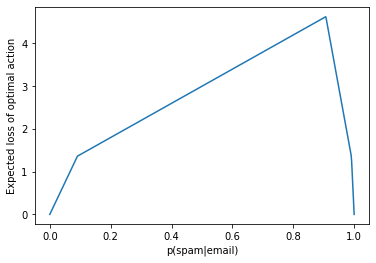

In [ ]:
prob_range = np.linspace(0., 1., num=600)
optimal_losses = []
optimal_actions = []
for p in prob_range: #Loop through probability range
    # TODO: Compute the optimal action and its expected loss for
    # probability of spam given by p.
    opt_action = optimal_action(p) #Find optimal action
    opt_loss = expected_loss_of_action(p, opt_action) #Find expected loss
    optimal_actions.append(opt_action)
    optimal_losses.append(opt_loss)

plt.xlabel('p(spam|email)')
plt.ylabel('Expected loss of optimal action')
plt.plot(prob_range, optimal_losses)

## Q1.4
[4pts] For exactly which range of the probabilities of an email being spam should we delete an email?

Find the exact answer by hand using algebra.

Range where deleting an email is better than listing as important email:\
15p > 150(1-p)\
15p > 150-150p\
165p > 150\
p > 150/165

Range where deleting an email is better than show the email to the user:\
5p+(1-p) > 150(1-p)\
4p+1 > 150-150p\
154p > 149\
p > 149/154

Range where deleting an email is better than putting the email in spam folder:\
p+40(1-p) > 150(1-p)\
p+40-40p > 150-150p\
111p > 110\
p > 110/111

Putting the email in spam folder is the limiting factor so range of probabilities of an email being spam should be deleted is 110/111 < p ≤ 1.


# Q2 - Naïve Bayes, A Generative Model

![](https://github.com/zalandoresearch/fashion-mnist/blob/master/doc/img/fashion-mnist-sprite.png?raw=true)


In this question, we'll fit a Naïve Bayes model to the fashion MNIST dataset, and use this model for making predictions and generating new images from the same distribution. Fashion MNIST is a dataset of 28x28 black-and-white images of items of clothing. We represent each image by a vector $x^{(i)} \in \{0,1\}^{784}$, where 0 and 1 represent white and black pixels respectively. Each class label $c^{(i)}$ is a different item of clothing, which in the code is represented by a 10-dimensional one-hot vector.

The Naïve Bayes model parameterized by $\theta$ and $\pi$ defines the following joint probability of $x$ and $c$,
$$p(x,c|\theta,\pi) = p(c|\pi)p(x|c,\theta) = p(c|\pi)\prod_{j=1}^{784}p(x_j|c,\theta),$$
where $x_j | c,\theta \sim \operatorname{Bernoulli}(\theta_{jc})$ or in other words $p(x_j | c,\theta) = \theta_{jc}^{x_j}(1-\theta_{jc})^{1-x_j}$, and $c|\pi$ follows a simple categorical distribution, i.e. $p(c|\pi) = \pi_c$.

We begin by learning the parameters $\theta$ and $\pi$. The following code will download and prepare the training and test sets.

In [ ]:
import numpy as np
import os
import gzip
import struct
import array
import matplotlib.pyplot as plt
import matplotlib.image
from urllib.request import urlretrieve

def download(url, filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    out_file = os.path.join('data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)


def fashion_mnist():
    base_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'

    def parse_labels(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ['train-images-idx3-ubyte.gz',
                     'train-labels-idx1-ubyte.gz',
                     't10k-images-idx3-ubyte.gz',
                     't10k-labels-idx1-ubyte.gz']:
        download(base_url + filename, filename)

    train_images = parse_images('data/train-images-idx3-ubyte.gz')
    train_labels = parse_labels('data/train-labels-idx1-ubyte.gz')
    test_images = parse_images('data/t10k-images-idx3-ubyte.gz')
    test_labels = parse_labels('data/t10k-labels-idx1-ubyte.gz')
    # Remove the data point that cause log(0)
    remove = (14926, 20348, 36487, 45128, 50945, 51163, 55023)
    train_images = np.delete(train_images,remove, axis=0)
    train_labels = np.delete(train_labels, remove, axis=0)
    return train_images, train_labels, test_images[:1000], test_labels[:1000]


def load_fashion_mnist():
    partial_flatten = lambda x: np.reshape(x, (x.shape[0], np.prod(x.shape[1:])))
    one_hot = lambda x, k: np.array(x[:, None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels =  fashion_mnist()
    train_images = (partial_flatten(train_images) / 255.0 > .5).astype(float)
    test_images = (partial_flatten(test_images) / 255.0 > .5).astype(float)
    train_labels = one_hot(train_labels, 10)
    test_labels = one_hot(test_labels, 10)
    N_data = train_images.shape[0]

    return N_data, train_images, train_labels, test_images, test_labels

## Q2.1
[2pts] Derive the expression for the Maximum Likelihood Estimator (MLE) of $\theta$ and $\pi$.

The Maximum Likelihood Estimator (MLE) is the set of parameters that maximize the likelihood of the observed data. For the Naive Bayes model, the likelihood of the observed data is given by
$$L(\theta, \pi) = \prod_{i=1}^N p(x^{(i)},c^{(i)}|\theta,\pi) = \prod_{i=1}^N p(c^{(i)}|\pi)\prod_{j=1}^{784}p(x_j^{(i)}|c^{(i)},\theta)$$

$$\log L(\theta, \pi) = \sum_{i=1}^N \log p(c^{(i)}|\pi) + \sum_{i=1}^N\sum_{j=1}^{784} \log p(x_j^{(i)}|c^{(i)},\theta)$$

For calculating the the MLE for $\pi$ use the first term because the second term does not depend on $\pi$.
$$\log L(\pi) = \sum_{i=1}^{N} \log p(c^{(i)}|\pi)$$

$$\log L(\pi) = \sum_{i=1}^{N} \log \pi_{c^{(i)}}$$

Differentiate the log likelihood with respect to $\pi$ and set it to zero to find the maximum likelihood

$$\frac{\partial \log L(\pi)}{\partial \pi_c} = \sum_{i=1}^{N} \frac{1}{\pi_{c^{(i)}}} \frac{\partial \pi_{c^{(i)}}}{\partial \pi_c} = 0$$

$$\sum_{i=1}^{N} \frac{1}{\pi_{c}} [c^{(i)} = c] = 0$$
Where $[c^{(i)} = c]$ is 1 if $c^{(i)} = c$ and 0 otherwise.

The MLE for $\pi$ can be computed as:
$$\hat{\pi}_c  = \frac{1}{N} \sum_{i=1}^N [c^{(i)} = c],$$

A simplified version is:
$$\hat{\pi}_c = \frac{N_c}{N}$$
Where $N_c$ is the number of samples in class c.

To calculate MLE for $\theta$ use second term in the log likelihood for the model.
$$L(\theta) = \sum_{i=1}^N\sum_{j=1}^{784} \log p(x_j^{(i)}|c^{(i)},\theta)$$

$$L(\theta) = \sum_{i=1}^N\sum_{j=1}^{784} x_j^{(i)} \log \theta_{j c^{(i)}} + (1 - x_j^{(i)}) \log (1 - \theta_{j c^{(i)}})$$

Taking the derivative of this expression with respect to $\theta_{j c}$ and setting it to zero using similar logic to the previous case gives:

$$\frac{\partial \log L(\theta)}{\partial \theta_{j c}} = \frac{\sum_{i=1}^N x_j^{(i)}[c^{(i)} = c]}{\theta_{j c}} - \frac{\sum_{i=1}^N (1 - x_j^{(i)})[c^{(i)} = c]}{1 - \theta_{j c}} = 0$$

Solving for $\hat{\theta}_{j c}$ gives:
$$\hat{\theta}_{j c} = \frac{\sum_{i=1}^N x_j^{(i)} [c^{(i)} = c]}{\sum_{i=1}^N [c^{(i)} = c]}$$

where $\sum_{i=1}^N x_j^{(i)} [c^{(i)} = c]$ counts the number of times pixel $j$ is black (i.e. $x_j = 1$) in images of class $c$, and $\sum_{i=1}^N [c^{(i)} = c]$ is the total number of images in class $c$.

A version in simple to understand terms is:
$$\hat{\theta}_{j c} = \frac{N_{b|c}}{N_c}$$
Where $N_{b|c}$ is the number of samples with a black pixel in pixel j given it is in class c and $N_c$ is the number of samples in class c.

## Q2.2
[4pts] Using the MLE for this data, many entries of $\theta$ will be estimated to be 0, which seems extreme. So we look for another estimation method.

Assume the prior distribution of $\theta$ is such that the entries are i.i.d. and drawn from $\operatorname{Beta}(2,2)$. Derive the Maximum A Posteriori (MAP) estimator for $\theta$ (it has a simple final form). You can return the MLE for $\pi$ in your implementation. From now on, we will work with this estimator.

Consider the log posterior distribution of $\theta_{jc}$ given the observed data $x$:

$$\log p(\theta_{jc}|x) = \log p(x|\theta_{jc}) + \log p(\theta_{jc}) - \log p(x)$$

Where $p(x|\theta_{jc})$ is the likelihood, $p(\theta_{jc})$ is the prior, and $p(x)$ is the marginal likelihood, which can be ignored since it is constant with respect to $\theta_{jc}$.

The likelihood is given by

$p(x|\theta_{jc}) = \prod_{i=1}^{N} \theta_{jc}^{x_j^{(i)}} (1 - \theta_{jc})^{1-x_j^{(i)}}$

and the prior is given by the Beta distribution

$p(\theta_{jc}) = \operatorname{Beta}(2,2) = \frac{1}{6} \theta_{jc} (1 - \theta_{jc})$.

So we have:
$$\log p(\theta_{jc}|x) = \sum_{i=1}^{N} x_j^{(i)} \log \theta_{jc} + (1 - x_j^{(i)}) \log (1 - \theta_{jc}) + \log \theta_{jc} + \log (1 - \theta_{jc}) + \log \frac{1}{6}$$

$$\log p(\theta_{jc}|x) = \sum_{i=1}^{N} (x_j^{(i)}+1) \log \theta_{jc} + (2 - x_j^{(i)}) \log (1 - \theta_{jc}) + \frac{1}{6}$$

Taking the derivative with respect to $\theta_{jc}$ using the same logic as previous cases and setting it to zero gives:
$$\frac{\partial \log p(\theta_{jc}|x)}{\partial \theta_{j c}} = \frac{\sum_{i=1}^N (x_j^{(i)}+1)[c^{(i)} = c]}{\theta_{j c}} - \frac{\sum_{i=1}^N (2 - x_j^{(i)})[c^{(i)} = c]}{1 - \theta_{j c}} = 0$$

Solving for $\hat{\theta}_{j c}$ gives:
$$\hat{\theta}_{j c} = \frac{\sum_{i=1}^N (x_j^{(i)}+1) [c^{(i)} = c]}{\sum_{i=1}^N 3[c^{(i)} = c]}$$

A version in simple to understand terms is:
$$\hat{\theta}_{j c} = \frac{N_{w|c}+2N_{b|c}}{3N_c}$$
Where $N_{w|c}$ and $N_{b|c}$ are the number of samples with a white or black pixel in pixel j given it is in class c respectively and $N_c$ is the number of samples in class c. Here a black pixel is worth 2 and a white pixel is worth 1.

In [ ]:
def train_map_estimator(train_images, train_labels):
    """ Inputs: train_images (N_samples x N_features), train_labels (N_samples x N_classes)
        Returns the MAP estimator theta_est (N_features x N_classes) and the MLE
        estimator pi_est (N_classes)"""

    # YOU NEED TO WRITE THIS PART
    N_samples, N_classes = train_labels.shape
    N_features = train_images.shape[1]
    #Change class labels to numbers
    class_labels = np.argmax(train_labels, axis=1)
    #Sum over labels to find number of each class
    class_nums = np.sum(train_labels, axis=0)
    #Find number per class over all samples
    pi_est = class_nums/N_samples
    theta_est = np.zeros((N_features,N_classes))

    # Create new training images adding one to pixel value
    new_train_images = train_images + np.ones((N_samples,N_features))
    for i in range(N_samples):
      im = new_train_images[i,:]
      c = class_labels[i]
      # Add image to theta
      theta_est[:,c] += im

    #Divide by number of pixels in each class
    theta_est = np.divide(theta_est,3*class_nums)
    return theta_est, pi_est


## Q2.3
[5pts] Derive an expression for the class log-likelihood $\log p(c|x,\theta,\pi)$ for a single image. Then, complete the implementation of the following functions. Recall that our prediction rule is to choose the class that maximizes the above log-likelihood, and accuracy is defined as the fraction of samples that are correctly predicted.

Report the average log-likelihood $\frac{1}{N}\sum_{i=1}^{N}\log p(c^{(i)}|x^{(i)},\hat{\theta},\hat{\pi})$ (where $N$ is the number of samples) on the training test, as well the training and test errors.

Note that class log-likelihood is:
$$\log p(c|x,\theta,\pi) = \log \frac{p(c, x | \theta, \pi)}{p(x|\theta,\pi)}$$

From joint probability distribution $p(c, x | \theta, \pi) = p(c|\pi) p(x|c,\theta)$ so

$$\log p(c|x,\theta,\pi) = \log \frac{p(c|\pi) p(x|c,\theta)}{p(x|\theta,\pi)}$$

Replace the denomiator with the total probability, marginalizing out c:
$$\log p(c|x,\theta,\pi) = \log \frac{p(c|\pi) p(x|c,\theta)}{\sum_c p(c|\pi) p(x|c,\theta)}$$

Replace terms with distribution:
$$\log \frac{p(c|\pi) p(x|c,\theta)}{\sum_c p(c|\pi) p(x|c,\theta)} = \log \frac{p(c|\pi) \prod_{j=1}^{784} \theta_{jc}^{x_j} (1 - \theta_{jc})^{1-x_j}}{\sum_c p(c|\pi) \prod_{j=1}^{784} \theta_{jc}^{x_j} (1 - \theta_{jc})^{1-x_j}}$$

Simplify numerator and denominator using the definition of the class prior $p(c|\pi)$:

$$\log p(c|x,\theta,\pi) = \log \frac{\pi_c \prod_{j=1}^{784} \theta_{jc}^{x_j} (1 - \theta_{jc})^{1-x_j}}{\sum_c \pi_c \prod_{j=1}^{784} \theta_{jc}^{x_j} (1 - \theta_{jc})^{1-x_j}}$$

$$\log p(c|x,\theta,\pi) = \log \pi_c + \sum_{j=1}^{784} x_j\log\theta_{jc}+(1-x_j)\log(1 - \theta_{jc})- \log \sum_c \pi_c \prod_{j=1}^{784} \theta_{jc}^{x_j} (1 - \theta_{jc})^{1-x_j}$$

In [ ]:
def log_likelihood(images, theta, pi):
    """ Inputs: images (N_samples x N_features), theta, pi
        Returns the matrix 'log_like' of loglikehoods over the input images where
        log_like[i,c] = log p (c |x^(i), theta, pi) using the estimators theta and pi.
        log_like is a matrix of (N_samples x N_classes)
    Note that log likelihood is not only for c^(i), it is for all possible c's."""

    # YOU NEED TO WRITE THIS PART
    N_samples, N_features = images.shape
    N_classes = theta.shape[1]

    # Calculate log likelihoods for each class and each image
    log_like = np.zeros((N_samples, N_classes))

    for i in range(N_samples):
        x = images[i,:]
        norm = 0
        for c in range(N_classes):
            # Find sum of the log of 784 terms
            log_theta_c = np.sum(x * np.log(theta[:,c]) + (1 - x) * np.log(1 - theta[:,c]))
            log_like[i,c] = np.log(pi[c]) + log_theta_c
            # Take exponential to convert back to product
            norm += np.exp(log_like[i,c])

        #Subtract the log product
        log_like[i,:] = log_like[i,:] - np.log(norm)

    return log_like

def accuracy(log_like, labels):
    """ Inputs: matrix of log likelihoods and 1-of-K labels (N_samples x N_classes)
    Returns the accuracy based on predictions from log likelihood values"""
    N_samples = labels.shape[1]
    # YOU NEED TO WRITE THIS PART

    # Get class labels
    class_labels = np.argmax(train_labels, axis=1)

    # Get highest likelihood
    highest_like = np.argmax(log_like, axis=1)

    # Find number that class label matches highest likelihood
    num_correct = 0
    for i in range(N_samples):
      if highest_like[i] == class_labels[i]:
        num_correct+=1
    accuracy = num_correct/N_samples
    return accuracy


N_data, train_images, train_labels, test_images, test_labels = load_fashion_mnist()
theta_est, pi_est = train_map_estimator(train_images, train_labels)
loglike_train = log_likelihood(train_images, theta_est, pi_est)
avg_loglike = np.sum(loglike_train * train_labels) / N_data
train_accuracy = accuracy(loglike_train, train_labels)
loglike_test = log_likelihood(test_images, theta_est, pi_est)
test_accuracy = accuracy(loglike_test, test_labels)

print(f"Average log-likelihood for MAP is {avg_loglike:.3f}")
print(f"Training accuracy for MAP is {train_accuracy:.3f}")
print(f"Test accuracy for MAP is {test_accuracy:.3f}")

Average log-likelihood for MAP is -15.696
Training accuracy for MAP is 0.500
Test accuracy for MAP is 0.100


## Q2.4
[2pts] Given this model's assumptions, is it always true that any two pixels $x_i$ and $x_j$ with $i \neq j$ are indenepdent given $c$? How about after marginalizing over $c$? Explain your answer.

The model assumes that the pixels in an image are conditionally independent given the class label c, meaning that the probability of each pixel is only dependent on the class label and not on the values of other pixels in the image.

After marginalizing over c, the pixels in an image are no longer independent as the marginal distribution of the pixels depends on the prior probability of each class, which is influenced by the relationship between the pixels and the class labels. The marginal distribution of the pixels takes into account the dependencies between the pixels and the class labels.

## Q2.5
[4pts] Since we have a generative model for our data, we can do more than just prediction. Randomly sample and plot 10 images from the learned distribution using the MAP estimates. (Hint: You first need to sample the class $c$, and then sample pixels conditioned on $c$.)

We have the MAP estimate for $\theta$:

$${\theta}_{j c} = \frac{N_{w|c}+2N_{b|c}}{3N_c}$$

We know that $N_{w|c} + N_{b|c} = N_c$. Substituting in $N_{b|c} = N_c-N_{w|c}$ into the MAP estimate gives:

$${\theta}_{j c} = \frac{N_{w|c}+2(N_c-N_{w|c})}{3N_c} = \frac{2N_c-N_{w|c}}{3N_c}$$

Solving for $N_{w|c}$ we have $N_{w|c} = 2N_c - 3N_c{\theta}_{j c}$. \

Dividing by $N_c$ we get a probability distribution for $N_{w|c}$, $\frac{N_{w|c}}{N_c} = 2 - 3{\theta}_{j c}$. Since $\frac{N_{w|c}}{N_c} + \frac{N_{b|c}}{N_c} = 1$, we have $\frac{N_{b|c}}{N_c} = 3{\theta}_{j c} - 1$.



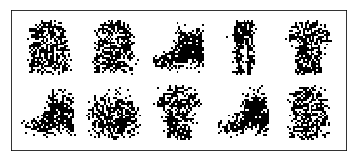

In [ ]:
def image_sampler(theta, pi, num_images):
    """ Inputs: parameters theta and pi, and number of images to sample
    Returns the sampled images (N_images x N_features)"""

    # YOU NEED TO WRITE THIS PART

    N_features = theta.shape[0]
    N_classes = theta.shape[1]

    images = np.zeros((num_images, N_features))
    for i in range(num_images):
        # Sample class
        c = np.random.choice(N_classes, p=pi)
        # Sample pixels conditioned on class
        for j in range(N_features):

          # Sample distribution calculated above
          p_bw = np.array([2-3*theta[j,c],3*theta[j,c]-1])
          images[i,j] = np.random.choice(2,p=p_bw)

    return images

def plot_images(images, ims_per_row=5, padding=5, image_dimensions=(28, 28),
                cmap=matplotlib.cm.binary, vmin=0., vmax=1.):
    """Images should be a (N_images x pixels) matrix."""
    fig = plt.figure(1)
    fig.clf()
    ax = fig.add_subplot(111)

    N_images = images.shape[0]
    N_rows = np.int32(np.ceil(float(N_images) / ims_per_row))
    pad_value = vmin
    concat_images = np.full(((image_dimensions[0] + padding) * N_rows + padding,
                             (image_dimensions[1] + padding) * ims_per_row + padding), pad_value)
    for i in range(N_images):
        cur_image = np.reshape(images[i, :], image_dimensions)
        row_ix = i // ims_per_row
        col_ix = i % ims_per_row
        row_start = padding + (padding + image_dimensions[0]) * row_ix
        col_start = padding + (padding + image_dimensions[1]) * col_ix
        concat_images[row_start: row_start + image_dimensions[0],
                      col_start: col_start + image_dimensions[1]] = cur_image
        cax = ax.matshow(concat_images, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))

    plt.plot()

sampled_images = image_sampler(theta_est, pi_est, 10)
plot_images(sampled_images)

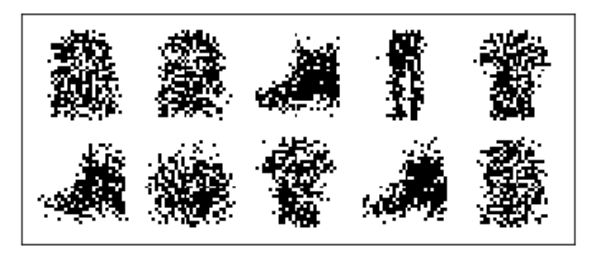

## Q2.6
[4pts] One of the advantages of generative models is that they can handle missing data, or be used to answer different sorts of questions about the model. Assume we have only observed some pixels of the image. Let $x_E = \{x_p : \text{pixel $p$ is observed}\}$. Derive an expression for $p(x_j|x_E,\theta,\pi)$, the conditional probability of an unobserved pixel $j$ given the observed pixels and distribution parameters. (Hint: You have to marginalize over $c$.)

We have after marginalizing over c:

$$p(x_j|x_E,\theta,\pi) = \sum_{c=1}^C p(x_j|c,\theta)p(c|x_E,\pi)$$

$p(c|x_E,\pi)$ can be found using Bayes theorem:

$$p(c|x_E,\pi) = \frac{p(x_E|c,\theta)p(c|\pi)}{\sum_{c'=1}^C p(x_E|c',\theta)p(c'|\pi)}$$

Therefore,

$$p(x_j|x_E,\theta,\pi) = \sum_{c=1}^C p(x_j|c,\theta) \frac{p(x_E|c,\theta)p(c|\pi)}{\sum_{c'=1}^C p(x_E|c',\theta)p(c'|\pi)}$$

$$p(x_j|x_E,\theta,\pi) = \sum_{c=1}^C \theta_{jc}^{x_j}(1-\theta_{jc})^{1-x_j} \frac{p(x_E|c,\theta)p(c|\pi)}{\sum_{c'=1}^C p(x_E|c',\theta)p(c'|\pi)}$$

The expression for $p(x_E|c,\theta)$ can be given as:
$$p(x_E|c,\theta) = \prod_{p \in E}p(x_p|c,\theta) = \prod_{p \in E}\theta_{pc}^{x_p}(1-\theta_{pc})^{1-x_p}$$

So the final expression is:
$$p(x_j|x_E,\theta,\pi) = \sum_{c=1}^C \theta_{jc}^{x_j}(1-\theta_{jc})^{1-x_j} \frac{\pi_c\prod_{p \in E}\theta_{pc}^{x_p}(1-\theta_{pc})^{1-x_p}}{\sum_{c'=1}^C \pi_{c'}\prod_{p \in E}\theta_{pc'}^{x_p}(1-\theta_{pc'})^{1-x_p}}$$

## Q2.7
[4pts] We assume that only 30% of the pixels are observed. For the first 20 images in the training set, plot the images when the unobserved pixels are left as white, as well as the same images when the unobserved pixels are filled with the marginal probability of the pixel being 1 given the observed pixels, i.e. the value of the unobserved pixel $j$ is $p(x_j = 1|x_E,\theta,\pi)$.

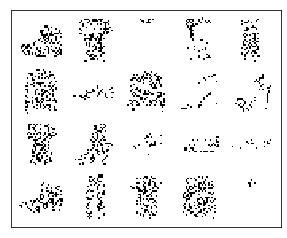

In [ ]:
def probabilistic_imputer(theta, pi, original_images, is_observed):
    """Inputs: parameters theta and pi, original_images (N_images x N_features),
        and is_observed which has the same shape as original_images, with a value
        1. in every observed entry and 0. in every unobserved entry.
    Returns the new images where unobserved pixels are replaced by their
    conditional probability"""

    # YOU NEED TO WRITE THIS PART
    N_images, N_features = original_images.shape
    N_classes = theta_est.shape[1]
    new_images = np.copy(original_images)

    # Calculate product and sum of products and store them in array prods for
    # each image
    for i in range(N_images):
      sum_prods = 0
      prods = np.zeros(N_classes)
      for c in range(N_classes): #loop through all classes
        prod = pi[c]
        for p in range(N_features):
          if is_observed[i,p] == 1: #only multiply through the observed pixels
            if original_images[i,p] == 1:
              prod*=theta[p,c] #if original image had observed black pixel
                               #multiply by theta
            else:
              prod*=(1-theta[p,c]) #if original image had observed white pixel
                                   #multiply by 1-theta
        prods[c] = prod
        sum_prods += prod

      for j in range(N_features): #loop through all features
        if is_observed[i,j] == 0: #only find marginal prob if feature is
                                  #unobserved
          sum = 0                 #sum over all classes and multiplying by
                            #theta_jc because find probability of black pixel

          for c in range(N_classes):
            sum += theta[j, c]*prods[c]/sum_prods
          new_images[i,j] = sum

    return new_images

num_features = train_images.shape[1]
is_observed = np.random.binomial(1, p=0.3, size=(20, num_features))
plot_images(train_images[:20] * is_observed)

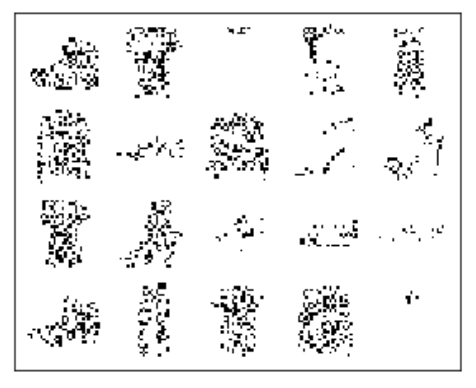

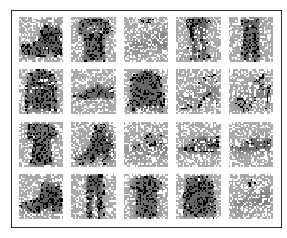

In [ ]:
imputed_images = probabilistic_imputer(theta_est, pi_est, train_images[:20], is_observed)
plot_images(imputed_images)

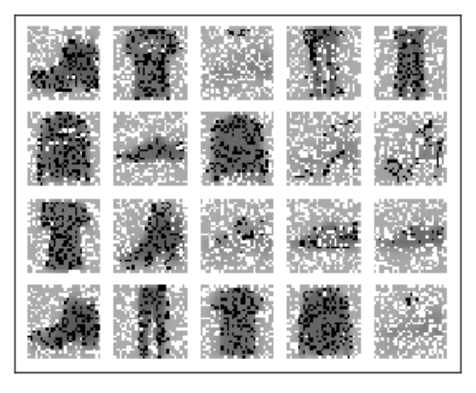